In [104]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from torchvision.transforms import functional as F

from vit_pytorch.efficient import ViT

In [105]:

print(f"Torch: {torch.__version__}")

Torch: 2.1.2


In [106]:
# Training settings
batch_size = 64
epochs = 200
lr = 3e-5
gamma = 0.7
seed = 42

In [107]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [108]:
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),  # Przeskalowanie obrazów
#     transforms.ToTensor(),  # Konwersja do tensorów PyTorch
#     # Możesz dodać więcej przekształceń jeśli to konieczne
# ])

In [109]:
# data_dir = r'C:\Users\Jan\SGH\magisterka\dane\kvasir-dataset-v2\dane'
# full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)


In [110]:
# # Podział datasetu na treningowy i testowy
# train_size = int(0.8 * len(full_dataset))  # 80% na trening
# test_size = len(full_dataset) - train_size  # 20% na test

In [111]:
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [112]:
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [113]:
# print(len(train_data), len(train_loader))

In [114]:
device = 'cuda'

In [115]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.1 GB
Cached:    0.7 GB


In [116]:
# train_dir = r'C:\Users\Jan\SGH\magisterka\dane\dogs_vs_cats\train'
# test_dir = r'C:\Users\Jan\SGH\magisterka\dane\dogs_vs_cats\test'

In [117]:
# train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
# test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [118]:
# print(f"Train Data: {len(train_list)}")
# print(f"Test Data: {len(test_list)}")

In [119]:
# labels = [path.split('/')[-1].split('.')[0] for path in train_list]

In [120]:
# random_idx = np.random.randint(1, len(train_list), size=9)
# fig, axes = plt.subplots(3, 3, figsize=(16, 12))

# for idx, ax in enumerate(axes.ravel()):
#     img = Image.open(train_list[idx])
#     ax.set_title(labels[idx])
#     ax.imshow(img)

In [121]:
data_dir = r'C:\Users\Jan\SGH\magisterka\dane\kvasir-dataset-v2\dane'
# full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
base_dataset = datasets.ImageFolder(root=data_dir)

In [122]:
# Obliczenie rozmiarów dla podziału
num_train = int(0.8 * len(base_dataset))
num_val = len(base_dataset) - num_train


In [123]:
# Podział indeksów datasetu na treningowy, walidacyjny i testowy
indices = torch.randperm(len(base_dataset)).tolist()
train_indices = indices[:num_train]
val_indices = indices[num_train:num_train + num_val]
test_indices = indices[num_train + num_val:]

# Utworzenie podzbiorów z odpowiednimi indeksami
train_dataset = Subset(base_dataset, train_indices)
val_dataset = Subset(base_dataset, val_indices)
test_dataset = Subset(base_dataset, test_indices)

In [145]:
# Transformacje dla zbioru treningowego
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Losowe odbicie poziome
    transforms.RandomRotation(1.15),  # Losowe rotacje o +/- 2% * 180 stopni
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),  # Losowa zmiana ostrości
    # Dla losowego kontrastu nie ma dokładnego odpowiednika w torchvision
    # transforms.RandomContrast nie istnieje, ale można zaimplementować własną funkcję lub użyć ColorJitter
    transforms.ColorJitter(brightness=0, contrast=0.4, saturation=0, hue=0),  # Losowa zmiana kontrastu
    # Dla RandomZoom nie ma bezpośredniego odpowiednika, ale można użyć RandomResizedCrop,
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ToTensor(),
    # inne transformacje specyficzne dla treningu
])

# Transformacje dla zbioru walidacyjnego
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # inne transformacje specyficzne dla walidacji
])

# Transformacje dla zbioru testowego
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # inne transformacje specyficzne dla testowania
])

In [146]:
# Funkcje collate_fn dla każdego z zestawów danych
def train_collate_fn(batch):
    processed_batch = [(train_transform(x[0]), x[1]) for x in batch]
    return torch.utils.data.dataloader.default_collate(processed_batch)

def val_collate_fn(batch):
    processed_batch = [(val_transform(x[0]), x[1]) for x in batch]
    return torch.utils.data.dataloader.default_collate(processed_batch)

def test_collate_fn(batch):
    processed_batch = [(test_transform(x[0]), x[1]) for x in batch]
    return torch.utils.data.dataloader.default_collate(processed_batch)

# Tutaj umieść pozostałą część kodu, w tym definicje transformacji i DataLoaderów

# Utworzenie DataLoaderów z odpowiednimi transformacjami
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=train_collate_fn)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=val_collate_fn)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=test_collate_fn)

In [147]:
val_loader

In [148]:
print(len(valid_loader))

25


In [149]:
# # Dla pewności, że wszystkie obrazy zostaną uwzględnione, 
# # szczególnie jeśli full_dataset nie jest podzielny przez 10
# val_size = test_size = (len(full_dataset) - train_size) // 2
# # Reszta obrazów (jeśli są) zostanie dodana do zbioru testowego
# remainder = len(full_dataset) - train_size - val_size * 2
# test_size += remainder

In [150]:
# train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [151]:

# train_list, valid_list = train_test_split(train_list, 
#                                           test_size=0.2,
#                                           stratify=labels,
#                                           random_state=seed)

In [152]:
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [153]:
# print(f"Train Data: {len(train_list)}")
# print(f"Validation Data: {len(valid_list)}")
# print(f"Test Data: {len(test_list)}")

In [154]:
# train_transforms = transforms.Compose(
#     [
#         transforms.Resize((224, 224)),
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#     ]
# )

# val_transforms = transforms.Compose(
#     [
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ]
# )


# test_transforms = transforms.Compose(
#     [
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ]
# )

In [155]:
# class CatsDogsDataset(Dataset):
#     def __init__(self, file_list, transform=None):
#         self.file_list = file_list
#         self.transform = transform

#     def __len__(self):
#         self.filelength = len(self.file_list)
#         return self.filelength

#     def __getitem__(self, idx):
#         img_path = self.file_list[idx]
#         img = Image.open(img_path)
#         img_transformed = self.transform(img)

#         label = img_path.split("\\")[-1].split(".")[0]
#         label = 1 if label == "dog" else 0

#         return img_transformed, label

In [156]:
# train_data = CatsDogsDataset(train_list, transform=train_transforms)
# valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
# test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [157]:
# train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
# valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [158]:
# print(len(train_data), len(train_loader))

In [159]:
# print(len(valid_data), len(valid_loader))

In [160]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [161]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=8,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [162]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [163]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.7196 - acc: 0.3564 - val_loss : 1.0987 - val_acc: 0.5025



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.9265 - acc: 0.5739 - val_loss : 1.2940 - val_acc: 0.4544



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.8185 - acc: 0.6395 - val_loss : 0.9434 - val_acc: 0.5781



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.7612 - acc: 0.6631 - val_loss : 0.9804 - val_acc: 0.5750



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.7253 - acc: 0.6753 - val_loss : 1.0340 - val_acc: 0.5775



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.7068 - acc: 0.6822 - val_loss : 1.7769 - val_acc: 0.4169



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.7083 - acc: 0.6847 - val_loss : 1.1315 - val_acc: 0.5294



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6791 - acc: 0.6978 - val_loss : 1.2028 - val_acc: 0.5375



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6939 - acc: 0.6911 - val_loss : 1.0683 - val_acc: 0.5906



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6716 - acc: 0.6975 - val_loss : 0.9970 - val_acc: 0.5950



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6705 - acc: 0.6938 - val_loss : 1.2330 - val_acc: 0.5594



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6678 - acc: 0.7008 - val_loss : 0.9262 - val_acc: 0.6100



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6472 - acc: 0.7063 - val_loss : 1.3884 - val_acc: 0.5506



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6517 - acc: 0.7069 - val_loss : 1.0838 - val_acc: 0.5850



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6454 - acc: 0.7114 - val_loss : 1.1242 - val_acc: 0.5894



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6417 - acc: 0.7083 - val_loss : 1.1691 - val_acc: 0.5581



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6416 - acc: 0.7136 - val_loss : 1.0624 - val_acc: 0.6000



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6305 - acc: 0.7148 - val_loss : 1.1487 - val_acc: 0.5819



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6286 - acc: 0.7120 - val_loss : 1.1086 - val_acc: 0.5975



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6262 - acc: 0.7169 - val_loss : 1.1955 - val_acc: 0.5919



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.6289 - acc: 0.7144 - val_loss : 1.4515 - val_acc: 0.5619



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.6176 - acc: 0.7241 - val_loss : 1.1226 - val_acc: 0.5850



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.6089 - acc: 0.7233 - val_loss : 1.1849 - val_acc: 0.5856



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.6074 - acc: 0.7275 - val_loss : 1.2630 - val_acc: 0.5906



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.6222 - acc: 0.7191 - val_loss : 1.2062 - val_acc: 0.5725



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.6047 - acc: 0.7247 - val_loss : 1.1151 - val_acc: 0.6012



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.6018 - acc: 0.7291 - val_loss : 1.3901 - val_acc: 0.5631



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.6097 - acc: 0.7175 - val_loss : 1.1734 - val_acc: 0.5731



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.5964 - acc: 0.7309 - val_loss : 1.3965 - val_acc: 0.5437



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.6068 - acc: 0.7264 - val_loss : 1.3184 - val_acc: 0.5487



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.5997 - acc: 0.7339 - val_loss : 1.0994 - val_acc: 0.5963



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.5941 - acc: 0.7286 - val_loss : 1.1051 - val_acc: 0.6062



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.5981 - acc: 0.7219 - val_loss : 1.3526 - val_acc: 0.5412



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.5940 - acc: 0.7305 - val_loss : 1.4220 - val_acc: 0.5587



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.5985 - acc: 0.7284 - val_loss : 1.2752 - val_acc: 0.5631



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.5869 - acc: 0.7314 - val_loss : 0.9083 - val_acc: 0.6269



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.5883 - acc: 0.7334 - val_loss : 1.1517 - val_acc: 0.6125



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.5828 - acc: 0.7380 - val_loss : 1.1500 - val_acc: 0.5900



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.5721 - acc: 0.7378 - val_loss : 1.2055 - val_acc: 0.5794



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.5727 - acc: 0.7423 - val_loss : 1.2466 - val_acc: 0.5925



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.5694 - acc: 0.7416 - val_loss : 1.1272 - val_acc: 0.5881



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.5751 - acc: 0.7405 - val_loss : 1.2516 - val_acc: 0.5913



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.5576 - acc: 0.7486 - val_loss : 1.2197 - val_acc: 0.5875



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.5739 - acc: 0.7373 - val_loss : 1.2091 - val_acc: 0.5962



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.5709 - acc: 0.7416 - val_loss : 1.1359 - val_acc: 0.5987



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.5612 - acc: 0.7467 - val_loss : 1.1597 - val_acc: 0.5831



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.5597 - acc: 0.7450 - val_loss : 1.1639 - val_acc: 0.6000



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.5567 - acc: 0.7439 - val_loss : 1.0962 - val_acc: 0.6044



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.5604 - acc: 0.7469 - val_loss : 1.1762 - val_acc: 0.5831



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.5622 - acc: 0.7456 - val_loss : 1.1834 - val_acc: 0.5881



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.5548 - acc: 0.7453 - val_loss : 1.3238 - val_acc: 0.5675



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.5488 - acc: 0.7559 - val_loss : 1.1045 - val_acc: 0.6106



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.5410 - acc: 0.7511 - val_loss : 0.9617 - val_acc: 0.6200



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.5507 - acc: 0.7516 - val_loss : 1.1075 - val_acc: 0.6087



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.5440 - acc: 0.7547 - val_loss : 1.2783 - val_acc: 0.5900



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.5455 - acc: 0.7558 - val_loss : 1.1404 - val_acc: 0.6106



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.5359 - acc: 0.7564 - val_loss : 0.9777 - val_acc: 0.6106



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.5433 - acc: 0.7461 - val_loss : 1.0261 - val_acc: 0.6137



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.5375 - acc: 0.7567 - val_loss : 1.2372 - val_acc: 0.5913



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.5326 - acc: 0.7620 - val_loss : 1.3638 - val_acc: 0.5619



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.5373 - acc: 0.7573 - val_loss : 1.0587 - val_acc: 0.6094



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.5330 - acc: 0.7584 - val_loss : 1.1264 - val_acc: 0.6044



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.5380 - acc: 0.7578 - val_loss : 0.9368 - val_acc: 0.6194



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.5253 - acc: 0.7623 - val_loss : 1.0511 - val_acc: 0.6119



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.5343 - acc: 0.7592 - val_loss : 1.2302 - val_acc: 0.5856



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.5222 - acc: 0.7645 - val_loss : 1.0214 - val_acc: 0.6106



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.5243 - acc: 0.7637 - val_loss : 1.2164 - val_acc: 0.5944



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.5142 - acc: 0.7717 - val_loss : 1.0999 - val_acc: 0.5919



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.5142 - acc: 0.7680 - val_loss : 1.2995 - val_acc: 0.5881



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.5206 - acc: 0.7667 - val_loss : 1.1850 - val_acc: 0.5981



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.5107 - acc: 0.7703 - val_loss : 0.9536 - val_acc: 0.6012



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.5123 - acc: 0.7706 - val_loss : 1.1660 - val_acc: 0.5838



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.5157 - acc: 0.7645 - val_loss : 1.1327 - val_acc: 0.6012



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.5093 - acc: 0.7705 - val_loss : 1.1691 - val_acc: 0.6019



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.5011 - acc: 0.7792 - val_loss : 0.9936 - val_acc: 0.6219



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.5005 - acc: 0.7752 - val_loss : 1.0866 - val_acc: 0.6119



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.5009 - acc: 0.7747 - val_loss : 0.9683 - val_acc: 0.5944



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.5004 - acc: 0.7775 - val_loss : 0.9262 - val_acc: 0.6306



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.4964 - acc: 0.7811 - val_loss : 1.0701 - val_acc: 0.6113



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.4905 - acc: 0.7795 - val_loss : 1.1164 - val_acc: 0.5906



  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [166]:
type(train_losses[1])

torch.Tensor

In [181]:
train_accuracies[1].cpu().numpy()

array(0.573906, dtype=float32)

In [179]:
train_losses[1].cpu()

tensor(0.9265, grad_fn=<ToCopyBackward0>)

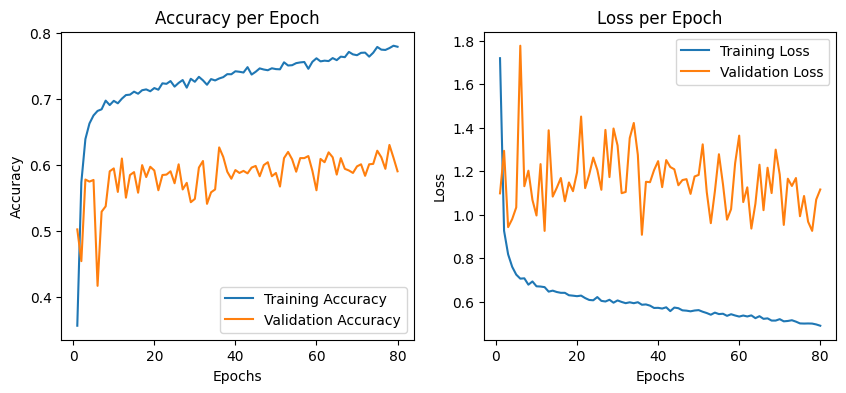

In [184]:
plt.figure(figsize=(10, 4))

# Wykres dokładności
plt.subplot(1, 2, 1)
# Upewniamy się, że dane są na CPU i konwertujemy je do NumPy
plt.plot(range(1, 81), [acc.cpu().numpy() for acc in train_accuracies], label='Training Accuracy')
plt.plot(range(1, 81), [acc.cpu().numpy() for acc in val_accuracies], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Wykres straty
plt.subplot(1, 2, 2)
# Podobnie jak wyżej, przenosimy dane na CPU
plt.plot(range(1, 81), [loss.cpu().detach().numpy() for loss in train_losses], label='Training Loss')
plt.plot(range(1, 81), [loss.cpu().detach().numpy() for loss in val_losses], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()